# Import our functions and data
The file "eda_functions" contains a list of methods that i created to simplify making graphs and piecharts. hope it helps! 

In [1]:
from eda_functions import *

df = get_and_clean_the_data("The Climate Change Twitter Dataset.csv")
df.head()
df.to_csv("climate_change_dataset.csv")

shape of our final dataframe: (586102, 11)


# (1) Data Exploration

In [4]:
# See all the words that exist in the column, and the counts of that word appearing
see_words_in_column(df, 'topic')

Weather Extremes                              244150
Global stance                                 173366
Importance of Human Intervantion              111573
Politics                                       73511
Donald Trump versus Science                    69132
Seriousness of Gas Emissions                   67916
Undefined / One Word Hashtags                  61869
Ideological Positions on Global Warming        42939
Impact of Resource Overconsumption             28187
Significance of Pollution Awareness Events     23072
Name: topic, dtype: int64

Next lets explore the distribution of latitude and longitude

/var/folders/2t/cdlbhtg57hg59jz8v2n_vf680000gn/T/ipykernel_10028/3638485375.py:19: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<AxesSubplot:>

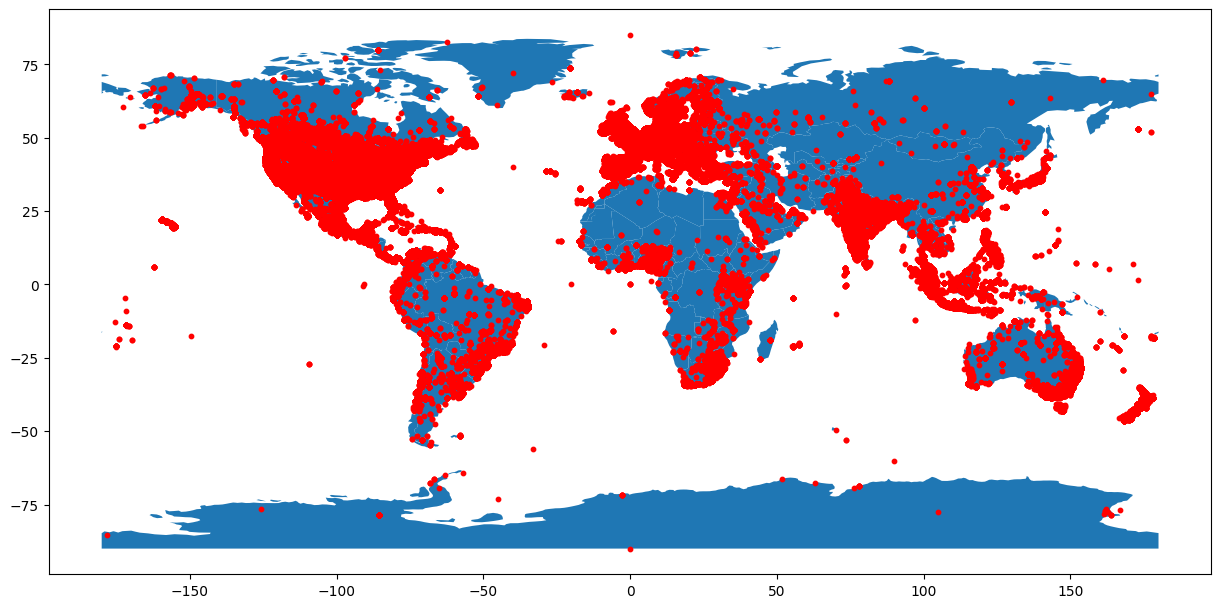

In [5]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['lng'],df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)

# Plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15,15)), marker='o',color='red',markersize=10)

Lets now explore the breakdown of stance

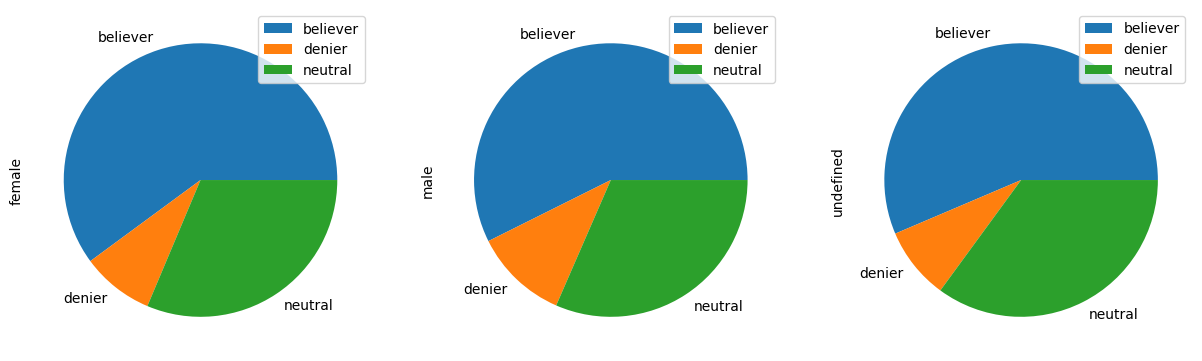

In [5]:
# Use pie charts to visualise breakdowns. 
# Change pie and slices to the respective columns you want to break down
pie_chart_based_on_columns(df, pie = 'gender', slices = 'stance')

In general there are more believers than deniers or neutrals

Next we explore the aggressiveness in each review

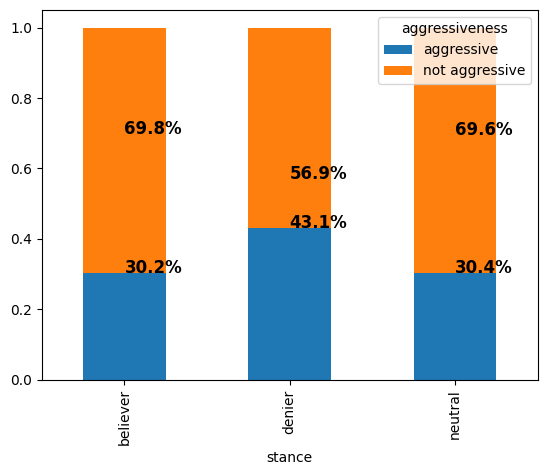

In [6]:
# Use bar charts to visualise breakdowns. 
# Change xaxis and yaxis to the respective columns you want to break down
bar_chart_based_on_columns(df, xaxis = 'stance', yaxis = 'aggressiveness')

In general there, believers are more aggressive than deniers in their tweets
Lets view average sentiments over the years

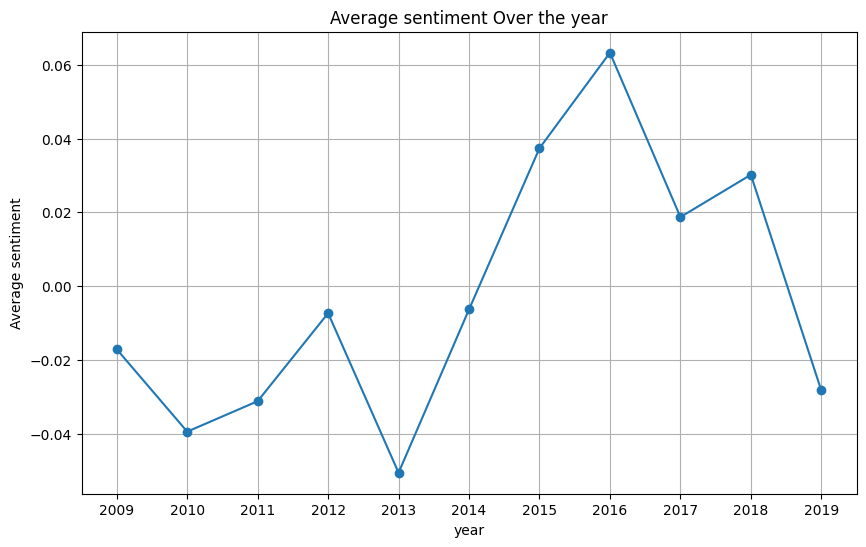

In [8]:
# Use line charts to visualise trends. 
# Change xaxis and yaxis to the respective columns you want to see trend
# yaxis MUST BE A NUMBER VARIABLE
line_chart_based_on_columns(df, xaxis = 'year', yaxis = 'sentiment')

## (2) Sentiment Analysis
To analyse actual tweets we use another dataset that contains tweets

In [25]:
tweets = pd.read_csv("twitter_sentiment_data.csv")
tweets.dropna(inplace=True)
tweets.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


### (2B) Feature engineering
We need to extract the date from the tweetid

In [26]:
# Define function to get the date
def get_tweet_timestamp(tid):
    offset = 1288834974657
    tstamp = (tid >> 22) + offset
    utcdttime = datetime.utcfromtimestamp(tstamp/1000)
    return utcdttime
    # print(str(tid) + " : " + str(tstamp) + " => " + str(utcdttime))

# Create 'date' column
tweets.date = tweets.tweetid.apply(lambda x: get_tweet_timestamp(x))
tweets.date

/var/folders/2t/cdlbhtg57hg59jz8v2n_vf680000gn/T/ipykernel_10028/2907640140.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tweets.date = tweets.tweetid.apply(lambda x: get_tweet_timestamp(x))


0       2016-10-31 03:13:07.701
1       2016-10-31 16:15:22.218
2       2016-10-31 16:16:07.725
3       2016-10-31 16:17:03.392
4       2016-10-31 16:19:07.444
                  ...          
43938   2016-10-26 15:54:32.840
43939   2016-10-26 16:33:35.418
43940   2016-10-26 19:15:07.538
43941   2016-10-26 21:24:24.018
43942   2016-10-26 22:10:22.085
Name: tweetid, Length: 43943, dtype: datetime64[ns]

For simplicity, tweets labelled 2 will be replaced with 1 for sentiment, as they both represent positive sentiment.

In [28]:
tweets.sentiment.replace(2,1,inplace=True)
tweets.sentiment.value_counts()

 1    32238
 0     7715
-1     3990
Name: sentiment, dtype: int64

Clean our twitter tweets

In [29]:
import re

# Define stop words
import nltk
from nltk.corpus import stopwords
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define a clean function
def clean(tweet):

    # Remove all usernames
    twt = re.sub("@\w*\d* +", '', tweet)

    # Remove all 'RT' at start of string
    twt = re.sub("^RT ", '', twt)

    # Remove all special characters
    twt = re.sub(r'[^a-zA-Z0-9\s]', '', twt).lower()

    # Remove all stopwords
    tokens = twt.split()
    tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

tweets['clean_message'] = tweets.message.apply(lambda x: clean(x))
tweets['clean_message']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tammyyuen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        climate change interesting hustle global warmi...
1        natgeochannel watch beforetheflood right trave...
2        fabulous leonardo dicaprios film climate chang...
3        mickfanning watched amazing documentary leonar...
4        cnalive pranita biswasi lutheran odisha gives ...
                               ...                        
43938    dear realdonaldtrump yeah right human mediated...
43939    respective parties prevent climate change glob...
43940    mikkil un poll shows climate change lowest glo...
43941    taehbeingextra still canqt believe gif taehyun...
43942    wealthy fossil fuel industry know climate chan...
Name: clean_message, Length: 43943, dtype: object

## (2C) Count words for sentiment
For positive sentiments:

In [30]:
pos_tweets = tweets[tweets.sentiment==1]
neg_tweets = tweets[tweets.sentiment==-1]

In [33]:
from collections import Counter
pos_common = Counter(" ".join(pos_tweets['clean_message']).split()).most_common(50)
pos_common

[('climate', 28072),
 ('change', 27192),
 ('global', 5674),
 ('warming', 5086),
 ('trump', 3541),
 ('believe', 1994),
 ('us', 1784),
 ('amp', 1710),
 ('doesnt', 1472),
 ('via', 1454),
 ('real', 1371),
 ('world', 1317),
 ('new', 1293),
 ('fight', 1232),
 ('people', 1207),
 ('going', 1119),
 ('shes', 1048),
 ('epa', 978),
 ('says', 973),
 ('dont', 955),
 ('scientists', 951),
 ('https', 922),
 ('trumps', 861),
 ('science', 842),
 ('like', 818),
 ('could', 799),
 ('say', 750),
 ('hoax', 734),
 ('donald', 698),
 ('need', 689),
 ('die', 682),
 ('action', 680),
 ('president', 661),
 ('one', 658),
 ('think', 632),
 ('news', 591),
 ('energy', 588),
 ('time', 578),
 ('climatechange', 573),
 ('thinking', 570),
 ('isnt', 535),
 ('husband', 519),
 ('know', 516),
 ('china', 516),
 ('paris', 512),
 ('may', 511),
 ('planet', 510),
 ('stephenschlegel', 507),
 ('httpstcosjofon', 507),
 ('help', 500)]

For negative sentiments:

In [32]:
neg_common = Counter(" ".join(neg_tweets['clean_message']).split()).most_common(20)
neg_common

[('climate', 2322),
 ('change', 2166),
 ('global', 1931),
 ('warming', 1847),
 ('amp', 214),
 ('us', 187),
 ('science', 182),
 ('hoax', 180),
 ('obama', 175),
 ('people', 162),
 ('real', 161),
 ('trump', 146),
 ('weather', 143),
 ('believe', 138),
 ('years', 132),
 ('like', 131),
 ('scam', 129),
 ('man', 125),
 ('made', 121),
 ('fake', 121)]